## AlBERTo multiclass
Adaptation of AlBERTo (originally intended to address 2 independent binary problems) to multiclass 

In [1]:
##
# For debugging
##

import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [2]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import itertools
import requests, re, string, datetime, copy
from functools import partial
import collections
import os

# to disable datasets outputs
import datasets
import logging
datasets.logging.get_verbosity = lambda: logging.NOTSET

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T, torch.nn.functional as F, torch.nn as nn

from datasets import Dataset
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback, TrainerCallback, AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from transformers.modeling_outputs import SequenceClassifierOutput

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score, f1_score

PATH = "./data/Sentipolc16/"
device = "cuda:0"

In [3]:
np.random.seed(0)
torch.manual_seed(0)

### read data

In [4]:
train = pd.read_csv(PATH + "training_set_sentipolc16.csv")
train.head()

idtwitter  subj  opos  oneg  iro  lpos  lneg  top  \
0  122449983151669248     1     0     1    0     0     1    1   
1  125485104863780865     1     0     1    0     0     1    1   
2  125513454315507712     1     0     1    0     0     1    1   
3  125524238290522113     1     0     1    0     0     1    1   
4  125527933224886272     1     0     1    0     0     1    1   

                                                text  
0  Intanto la partita per Via Nazionale si compli...  
1  False illusioni, sgradevoli realtà Mario Monti...  
2  False illusioni, sgradevoli realtà #editoriale...  
3  Mario Monti: Berlusconi risparmi all'Italia il...  
4  Mario Monti: Berlusconi risparmi all'Italia il...

In [5]:
file1 = open(PATH + "test_set_sentipolc16_gold2000.csv", 'r') 
Lines = file1.readlines()
 
test = []
for line in Lines:
    arr = line.split("\",")
    if len(arr) != 9:
        arr[8] = arr[8] + arr[9]  #to account for tweets containing the delimiter charachter that would create more splits than needed
        del arr[9:]
    for i in range(8):
        arr[i] = int(arr[i].strip("\""))
    test.append(arr)

test = pd.DataFrame(test, columns=train.columns)
test.head()

idtwitter  subj  opos  oneg  iro  lpos  lneg  top  \
0  507074506880712705     0     0     0    0     0     0    2   
1  507075789456961536     1     1     0    0     1     0    2   
2  507077511902425088     1     0     1    0     0     1    2   
3  507079183315787777     0     0     0    0     0     0    2   
4  507080190225563648     1     0     0    0     0     0    2   

                                                text  
0  "Tra 5 minuti presentazione piano scuola del g...  
1  "\"@matteorenzi: Alle 10 appuntamento su http:...  
2  "#labuonascuola gli #evangelisti #digitali non...  
3  "Riforma scuola Tutto il discorso di  Renzi su...  
4  ".@matteorenzi @MiurSocial #labuonascuola bast...

### preprocessing

In [6]:
class AlBERTo_Preprocessing(object):
    def __init__(self, do_lower_case=True, **kwargs):
        self.do_lower_case = do_lower_case
        self.text_processor = TextPreProcessor(
            # terms that will be normalized
            normalize=['url', 'email', 'user', 'percent', 'money', 'phone', 'time', 'date', 'number'],
            # terms that will be annotated
            annotate={"hashtag"},
            fix_html=True,  # fix HTML tokens

            unpack_hashtags=True,  # perform word segmentation on hashtags

            # select a tokenizer. You can use SocialTokenizer, or pass your own
            # the tokenizer, should take as input a string and return a list of tokens
            tokenizer=SocialTokenizer(lowercase=True).tokenize,
            dicts=[emoticons]
        )

    def preprocess(self, text):
        if self.do_lower_case:
            text = text.lower()
        text = str(" ".join(self.text_processor.pre_process_doc(text)))
        text = re.sub(r'[^a-zA-ZÀ-ú</>!?♥♡\s\U00010000-\U0010ffff]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'(\w)\1{2,}', r'\1\1', text)
        text = re.sub(r'^\s', '', text)
        text = re.sub(r'\s$', '', text)
        return text
    
preprocess = AlBERTo_Preprocessing(do_lower_case=True)
test_sentence = "#IlGOverno presenta le linee guida sulla scuola #labuonascuola - http://t.co/SYS1T9QmQN"
test_sentence = preprocess.preprocess(test_sentence)

/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading english - 1grams ...
Reading english - 2grams ...


/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading english - 1grams ...


### utility functions

In [7]:
def tokenize_function(examples):
    return tok(examples["text"], padding="max_length", truncation=True)

def separate2united_labels(row):
    """
        Return a single scalar integer label associated to the polarity of the tweet.

        Negative -> 0
        Neutral  -> 1
        Positive -> 2
        Mixed    -> 3
    """
    if row["opos"] == 0 and row["oneg"] == 0:
        return 1
    elif row["oneg"] == 0 and row["opos"] == 1:
        return 2
    elif row["oneg"] == 1 and row["opos"] == 0:
        return 0
    else:
        return 3

def get_scheduler(optimizer, num_epochs, warmup_steps, train_loader):
    num_train_steps = int(len(train_loader) * num_epochs) + 1
    num_warmup_steps =  int(num_train_steps * warmup_steps)
    return get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_train_steps)

In [8]:
class EarlyStopping():    
    def __init__(self, min_delta = 0, patience = 0):        
        self.min_delta = min_delta
        self.patience = patience
        self.wait = 0
        self.stopped_epoch = 0
        self.best = -np.Inf
        self.stop_training = False
    
    def on_epoch_end(self, epoch, current_value):
        if np.greater((current_value - self.min_delta), self.best):
            self.best = current_value
            self.wait = 0
        else:
            self.wait += 1
            if self.wait > self.patience:
                self.stopped_epoch = epoch
                self.stop_training = True
        return self.stop_training

### hyper-parameters

In [9]:
TRAIN_BATCH_SIZE   = 32 
PREDICT_BATCH_SIZE = 64
EVAL_BATCH_SIZE    = 64 
WEIGHT_DECAY       = 0.01
LEARNING_RATE      = 2e-5
NUM_EPOCHS         = 3
MAX_SEQ_LENGTH     = 128
WARMUP_PROPORTION  = 0.1

### load pretrained model

In [10]:
tok = AutoTokenizer.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
tok.model_max_length = MAX_SEQ_LENGTH #model.config.max_position_embeddings
pretrained_model = AutoModel.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")

test_tokens = tok.tokenize(test_sentence)
print(test_tokens)

['<', 'ha', '##shtag', '>', 'il', 'governo', '<', '/', 'ha', '##shtag', '>', 'presenta', 'le', 'linee', 'guida', 'sulla', 'scuola', '<', 'ha', '##shtag', '>', 'la', 'buona', 'scuola', '<', '/', 'ha', '##shtag', '>', '<', 'ur', '##l', '>']


### model definition

In [11]:
class AMC(nn.Module):
    def __init__(self, num_labels):
        super(AMC, self).__init__()

        self.num_labels = num_labels
        self.model = copy.deepcopy(pretrained_model)
        self.dropout1 = nn.Dropout(0.1)
        self.linear1 = nn.Linear(768, 3)

        self.loss_fct = nn.CrossEntropyLoss()

    def forward(self, labels, input_ids, attention_mask, **args):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, **args)
        x = self.dropout1(outputs[1])
        logits = self.linear1(x)
        loss = self.loss_fct(logits, labels)
        return logits , loss

### dataset

In [12]:
##
# train set
##
dataset = pd.DataFrame({"text": train.text.apply(preprocess.preprocess), "idx": train.index, "labels": train[["opos", "oneg"]].apply(separate2united_labels, axis=1)})
X_train, X_val = train_test_split(dataset, test_size=0.2, random_state=42, stratify=dataset["labels"])

X_train = Dataset.from_pandas(X_train)
X_val = Dataset.from_pandas(X_val)

training = X_train\
                    .map(tokenize_function, batched=True)\
                    .filter(lambda example: example['labels'] != 3)\
                    .shuffle(seed=42)
validating = X_val\
                    .map(tokenize_function, batched=True)\
                    .filter(lambda example: example['labels'] != 3)\
                    .with_format("torch")

train_loader = DataLoader(training.with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"]), shuffle=True, batch_size=TRAIN_BATCH_SIZE)
val_loader = DataLoader(validating.with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"]), batch_size=PREDICT_BATCH_SIZE)

##
# test set
##
dataset = pd.DataFrame({"text": test.text.apply(preprocess.preprocess), "idx": test.index, "labels": test[["opos", "oneg"]].apply(separate2united_labels, axis=1)})
dataset = Dataset.from_pandas(dataset)

testing = dataset\
                    .map(tokenize_function, batched=True)\
                    .filter(lambda example: example['labels'] != 3)\
                    .with_format("torch")
test_loader = DataLoader(testing.with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"]), shuffle=False, batch_size=PREDICT_BATCH_SIZE)

### training loops

In [13]:
def train_epoch(model, train_loader, optimizer, scheduler, epoch):
    model.train()
    outputs , targets = [] , []
    cumulative_loss = 0.
    for i , data in tqdm(enumerate(train_loader, 0), total=len(train_loader)):        
        targets.extend(data["labels"].numpy())
        
        batch = {k: v.to(device) for k, v in data.items()}
        logits , loss = model(**batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        cumulative_loss += loss.detach()
        outputs.extend(logits.argmax(-1).cpu().detach().numpy().tolist())
#         if (i+1) % 25 == 0:
#             print(f'Epoch: {epoch}, Loss:  {cumulative_loss.item()/i}')
    return outputs, targets
    
        
def validation_epoch(model, val_loader):
    model.eval()
    outputs , targets = [], []
    cumulative_loss = 0.
    with torch.no_grad():
        for _, data in enumerate(val_loader, 0):        
            batch = {k: v.to(device) for k, v in data.items()}
            logits , loss = model(**batch)
            cumulative_loss += loss.detach()    
            targets.extend(batch["labels"].cpu().detach().numpy())
            outputs.extend(logits.argmax(-1).cpu().detach().numpy().tolist())
#             if (i+1) % 25 == 0:
#                 print(f'Epoch: {epoch}, Loss:  {cumulative_loss.item()/i}')
    return outputs, targets

## Training AMC

In [14]:
np.random.seed(0)
torch.manual_seed(0)

hyper = {'learning_rate': LEARNING_RATE, 'warmup_steps': WARMUP_PROPORTION, 'weight_decay': WEIGHT_DECAY}
model = AMC(3).to(device)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=hyper["learning_rate"],
                              weight_decay=hyper["weight_decay"], 
                              eps=1e-6)
scheduler = get_scheduler(optimizer, NUM_EPOCHS, hyper["warmup_steps"], train_loader)

for epoch in range(NUM_EPOCHS):
    outputs, targets = train_epoch(model, train_loader, optimizer, scheduler, epoch)    
    f1_train = f1_score(targets, outputs, average='macro')    
    print(f"Train F1 = {f1_train}")
    outputs, targets = validation_epoch(model, test_loader)
    f1_test = f1_score(targets, outputs, average='macro')
    print(f"Test F1 = {f1_test}")
    
#torch.save(model.state_dict(), "data/models/alberto_multiclass.pt")    


Train F1 = 0.5976070832340551
Test F1 = 0.6526291958093347



Train F1 = 0.781953680661327
Test F1 = 0.6692637060631031



Train F1 = 0.8712555145406565
Test F1 = 0.6553107735633988


              precision    recall  f1-score   support

    negative       0.84      0.52      0.64       734
     neutral       0.69      0.82      0.75       914
    positive       0.50      0.66      0.57       316

    accuracy                           0.68      1964
   macro avg       0.68      0.67      0.66      1964
weighted avg       0.72      0.68      0.68      1964



Text(0.5, 1.0, 'SENTIPOLC16 - AMC')

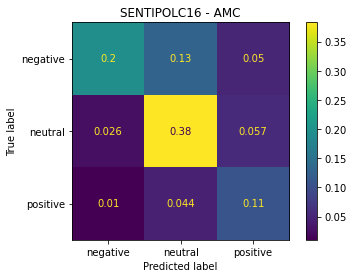

In [15]:
#load best model's params
#model = MyNetMC(3).to(device)
#model.load_state_dict(torch.load("data/models/alberto_multiclass.pt"))

preds , trues = validation_epoch(model, test_loader)

print(classification_report(trues, preds, target_names=["negative", "neutral", "positive"]))
cm = confusion_matrix(trues, preds, normalize='all')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"]).plot()
plt.title("SENTIPOLC16 - AMC")

## AMC + validation set

In [16]:
np.random.seed(0)
torch.manual_seed(0)

hyper = {'learning_rate': LEARNING_RATE, 'warmup_steps': WARMUP_PROPORTION, 'weight_decay': WEIGHT_DECAY}
model = AMC(3).to(device)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=hyper["learning_rate"],
                              weight_decay=hyper["weight_decay"], 
                              eps=1e-6)

scheduler = get_scheduler(optimizer, NUM_EPOCHS, hyper["warmup_steps"], train_loader)

best_value = 0
for epoch in range(NUM_EPOCHS):
    outputs, targets = train_epoch(model, train_loader, optimizer, scheduler, epoch)
    f1_train = f1_score(targets, outputs, average='macro')
    outputs, targets = validation_epoch(model, val_loader)
    f1_val = f1_score(targets, outputs, average='macro')
    
    if f1_val > best_value:
        best_value = f1_val
        #torch.save(model.state_dict(), "data/models/alberto_multiclass_val.pt")    
    
    print(f"Val F1 = {f1_val}")
    outputs, targets = validation_epoch(model, test_loader)
    f1_test = f1_score(targets, outputs, average='macro')
    print("Test F1=", f1_test)


Val F1 = 0.7011215639743481
Test F1= 0.6526291958093347



Val F1 = 0.7001458235203678
Test F1= 0.6937881839766747



Val F1 = 0.7088638892696988
Test F1= 0.6727223486079515


              precision    recall  f1-score   support

    negative       0.85      0.57      0.68       734
     neutral       0.70      0.82      0.76       914
    positive       0.52      0.67      0.58       316

    accuracy                           0.70      1964
   macro avg       0.69      0.68      0.67      1964
weighted avg       0.73      0.70      0.70      1964



Text(0.5, 1.0, 'SENTIPOLC16 - AMC val set')

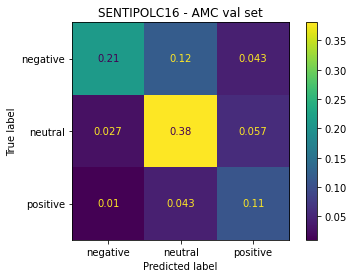

In [17]:
#load best model's params
#model = MyNetMC(3).to(device)
#model.load_state_dict(torch.load("data/models/alberto_multiclass_val.pt"))

preds , trues = validation_epoch(model, test_loader)

print(classification_report(trues, preds, target_names=["negative", "neutral", "positive"]))
cm = confusion_matrix(trues, preds, normalize='all')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"]).plot()
plt.title("SENTIPOLC16 - AMC val set")

## AMC + validation set + early stopping

In [19]:
np.random.seed(0)
torch.manual_seed(0)

hyper = {'learning_rate': LEARNING_RATE, 'warmup_steps': WARMUP_PROPORTION, 'weight_decay': WEIGHT_DECAY}
model = AMC(3).to(device)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=hyper["learning_rate"],
                              weight_decay=hyper["weight_decay"], 
                              eps=1e-6)

num_epochs = 15
early_stopping = EarlyStopping(min_delta=0.005, patience=3)
scheduler = get_scheduler(optimizer, num_epochs, hyper["warmup_steps"], train_loader)

best_value = 0
for epoch in range(num_epochs):
    outputs, targets = train_epoch(model, train_loader, optimizer, scheduler, epoch)
    f1_train = f1_score(targets, outputs, average='macro')
    outputs, targets = validation_epoch(model, val_loader)    
    f1_val = f1_score(targets, outputs, average='macro')
    
    if f1_val > best_value: 
        best_value = f1_val
        #torch.save(model.state_dict(), "data/models/alberto_multiclass_val_early.pt") 
        
    if early_stopping.on_epoch_end(epoch, f1_val):
        print("\n\nEARLY STOPPING AFTER {} EPOCHS".format(epoch))
        break
    
    print(f"Val F1 = {f1_val}")
    outputs, targets = validation_epoch(model, test_loader)
    f1_test = f1_score(targets, outputs, average='macro')
    print(f"Test F1 = {f1_test}")


Val F1 = 0.6566346059101814
Test F1 = 0.5692815440855629



Val F1 = 0.7108839354288662
Test F1 = 0.6337375931656731



Val F1 = 0.7068177079424044
Test F1 = 0.610608549496786



Val F1 = 0.6934170354608601
Test F1 = 0.6161200810718863



Val F1 = 0.6931839360371613
Test F1 = 0.6442934257113097





EARLY STOPPING AFTER 5 EPOCHS


              precision    recall  f1-score   support

    negative       0.76      0.56      0.64       734
     neutral       0.72      0.61      0.67       914
    positive       0.37      0.77      0.50       316

    accuracy                           0.62      1964
   macro avg       0.62      0.65      0.60      1964
weighted avg       0.68      0.62      0.63      1964



Text(0.5, 1.0, 'SENTIPOLC16 - AMC val set + early stopp.')

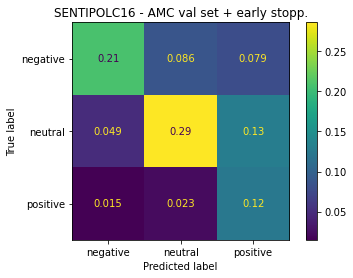

In [20]:
#load best model's params
#model = MyNetMC(3).to(device)
#model.load_state_dict(torch.load("data/models/alberto_multiclass_val_early.pt"))

preds , trues = validation_epoch(model, test_loader)

print(classification_report(trues, preds, target_names=["negative", "neutral", "positive"]))
cm = confusion_matrix(trues, preds, normalize='all')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"]).plot()
plt.title("SENTIPOLC16 - AMC val set + early stopp.")

## AMC opt

#### run HPT to get the best hyper-parameters, then train the model

In [21]:
best_hyper = None

In [ ]:
import optuna
from optuna.trial import TrialState

def objective(trial):
    lr = trial.suggest_float("learning_rate", 2e-6, 2e-3, log=True)
    wd = trial.suggest_float("weight_decay", 1e-6, 1e-1)
    warmup = trial.suggest_float("warmup_steps", 0., 0.9, step=0.3),
    num_epochs = trial.suggest_int("num_epochs", 1, 19, step=2)
    model_type = trial.suggest_int("model_type", 1, 2, step=1)
    if model_type == 1:
        model = MyNetMC(3).to(device)
    else:
        model = MyNetMCTuned(3).to(device)
    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=lr,
                                  weight_decay=wd, 
                                  eps=1e-6)
    early_stopping = EarlyStopping(min_delta=0.005, patience=3)

    num_epochs = int(num_epochs)
    print("num_epochs=", num_epochs)
    num_train_steps = int(len(train_loader) * num_epochs) + 1
    num_warmup_steps =  int(num_train_steps * warmup[0])
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_train_steps)

    logging = False    
    best_val = 0
    for epoch in range(num_epochs):
        outputs, targets = train_epoch(model, train_loader, optimizer, scheduler, epoch, logging)        
        outputs, targets = validation_epoch(model, val_loader)
        f1_val = f1_score(targets, outputs, average='macro')
        
        if f1_val > best_val:
            best_val = f1_val
            
        if early_stopping.on_epoch_end(epoch, f1_val):
            print("\n\nEARLY STOPPING AFTER {} EPOCHS".format(epoch))
            break

        trial.report(f1_val, epoch)
        
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()        
    return best_val


study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(
    n_startup_trials=5, n_warmup_steps=1)
)
study.optimize(objective, n_trials=50)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial
best_hyper = trial.params
print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [16]:
best_hyper

In [22]:
np.random.seed(0)
torch.manual_seed(0)

model = AMC(3).to(device)
if best_hyper is None:
    best_hyper = {'learning_rate': 6.599917952321265e-05, 'weight_decay': 0.02157165894420757, 'warmup_steps': 0.8999999999999999, 'num_epochs': 11}


optimizer = torch.optim.AdamW(model.parameters(),
                              lr=best_hyper["learning_rate"],
                              weight_decay=best_hyper["weight_decay"], 
                              eps=1e-6)
early_stopping = EarlyStopping(min_delta=0.005, patience=3)
scheduler = get_scheduler(optimizer, best_hyper["num_epochs"], best_hyper["warmup_steps"], train_loader)

best_value = 0
for epoch in range(num_epochs):
    outputs, targets = train_epoch(model, train_loader, optimizer, scheduler, epoch)
    f1_train = f1_score(targets, outputs, average='macro')
    outputs, targets = validation_epoch(model, val_loader)
    f1_val = f1_score(targets, outputs, average='macro')
    
    if f1_val > best_value:
        best_value = f1_val
        model_best = copy.deepcopy(model)
        #torch.save(model.state_dict(), "data/models/alberto_multiclass_tuned_0.69_AMC.pt")    
    if early_stopping.on_epoch_end(epoch, f1_val):
        print("\n\nEARLY STOPPING AFTER {} EPOCHS".format(epoch))
        break
    
    outputs, targets = validation_epoch(model, test_loader)
    f1_test = f1_score(targets, outputs, average='macro')
    print(f"Val F1 = {f1_val}")
    print("Test F1=", f1_test)


Val F1 = 0.6173029025578468
Test F1= 0.5740978719086977



Val F1 = 0.7062778042056173
Test F1= 0.6879802297256261



Val F1 = 0.6837537432562136
Test F1= 0.591878609235187



Val F1 = 0.6582144617208426
Test F1= 0.5563143900158543



Val F1 = 0.6371598808767666
Test F1= 0.5560702090733833





EARLY STOPPING AFTER 5 EPOCHS


              precision    recall  f1-score   support

    negative       0.86      0.58      0.70       734
     neutral       0.69      0.89      0.78       914
    positive       0.62      0.57      0.59       316

    accuracy                           0.72      1964
   macro avg       0.72      0.68      0.69      1964
weighted avg       0.74      0.72      0.72      1964



Text(0.5, 1.0, 'SENTIPOLC16 - AMC opt')

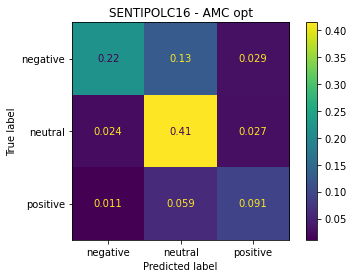

In [23]:
#load best model's params
#model = AMC(3).to(device)
#model.load_state_dict(torch.load("data/models/alberto_multiclass_tuned_0.69_AMC.pt"))
model_best.eval()
preds , trues = validation_epoch(model_best, test_loader)

print(classification_report(trues, preds, target_names=["negative", "neutral", "positive"]))
cm = confusion_matrix(trues, preds, normalize='all')
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negative", "neutral", "positive"]).plot()
plt.title("SENTIPOLC16 - AMC opt")